In [1]:
import sys
sys.path.append('../..'); sys.path.append('../'); 
import numpy as np
from setGame import *
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
import utils
from transformer_modules import Encoder, Decoder, AddPositionalEmbedding
from abstracters import SymbolicAbstracter, RelationalAbstracter

In [2]:
setgame = SetGame(verbose=0)
X, y, triples = setgame.generate_grouped_data()
inds = (y==True)
posi = np.arange(len(y))[inds]
negi = np.arange(len(y))[~inds][0:len(posi)]
inds = list(posi)+list(negi)
X_balanced = X[inds,:]
y_balanced = y[inds]
triples_balanced = np.array(triples)[inds]


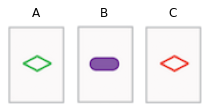

0


[1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0]

In [3]:
i = np.random.choice(range(len(y_balanced)))
setgame.show_triple(triples_balanced[i]), y_balanced[i]
attr = setgame.tabulate_attributes_for_triple(triples_balanced[i])
iattr = [int(attr[i]) for i in range(len(attr))]
print(y_balanced[i])
iattr


In [4]:
X = np.zeros((len(y_balanced), 12), dtype=int)
y = np.zeros(len(y_balanced), dtype=int)

for i in np.arange(len(y_balanced)):
    attr = setgame.tabulate_attributes_for_triple(triples_balanced[i])
    X[i] = [int(attr[i]) for i in range(len(attr))]
    y[i] = y_balanced[i]


In [27]:
train_size = 50
test_size = 0.3
val_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size/(1-test_size))

X_train.shape, X_val.shape, X_test.shape

((42, 12), (8, 12), (648, 12))

In [6]:
class TransformerClassifier(tf.keras.Model):
    def __init__(self, num_layers, num_heads, dff,
            input_vocab, embedding_dim, 
            dropout_rate=0.1, name='transformer_classifier'):

        super().__init__(name=name)

        if isinstance(input_vocab, int):
            self.source_embedder = layers.Embedding(input_vocab, embedding_dim, name='source_embedder')
        elif input_vocab == 'vector':
            self.source_embedder = layers.TimeDistributed(layers.Dense(embedding_dim), name='source_embedder')
        else:
            raise ValueError(
                "`input_vocab` must be an integer if the input sequence is token-valued or "
                "'vector' if the input sequence is vector-valued.")

        self.pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
        self.encoder = Encoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='encoder')
        self.flattener = layers.Flatten()
        self.final_layer = layers.Dense(2, name='final_layer')


    def call(self, inputs):
        source = inputs

        x = self.source_embedder(source)
        x = self.pos_embedding_adder_input(x)
        encoder_context = self.encoder(x)
        output = self.flattener(encoder_context)
        logits = self.final_layer(output)

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
          del logits._keras_mask
        except AttributeError:
          pass

        return logits
        
class AbstractorClassifier(tf.keras.Model):
    def __init__(self, num_layers, num_heads, dff,
            input_vocab, embedding_dim, dropout_rate=0.1, name='abstractor_classifier'):

        super().__init__(name=name)

        if isinstance(input_vocab, int):
            self.source_embedder = layers.Embedding(input_vocab, embedding_dim, name='source_embedder')
        elif input_vocab == 'vector':
            self.source_embedder = layers.TimeDistributed(layers.Dense(embedding_dim), name='source_embedder')
        else:
            raise ValueError(
                "`input_vocab` must be an integer if the input sequence is token-valued or "
                "'vector' if the input sequence is vector-valued.")

        self.pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
        self.encoder = Encoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='encoder')
        self.abstractor = RelationalAbstracter(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='abstractor')
        self.flattener = layers.Flatten()
        self.final_layer = layers.Dense(2, name='final_layer')


    def call(self, inputs):
        source = inputs

        x = self.source_embedder(source)
        x = self.pos_embedding_adder_input(x)
        encoder_context = self.encoder(x)
        abstracted_context = self.abstractor(encoder_context)
        outputs = self.flattener(abstracted_context)
        logits = self.final_layer(outputs)

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
          del logits._keras_mask
        except AttributeError:
          pass

        return logits


In [17]:
create_opt = lambda : tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='binary_crossentropy')

In [28]:
transformer_model = TransformerClassifier(num_layers=2, num_heads=2, dff=64, input_vocab=2, embedding_dim=64)
transformer_model.compile(loss=loss, optimizer=create_opt(), metrics=['accuracy'])
transformer_model(X[:32])
transformer_model.summary()

Model: "transformer_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 source_embedder (Embedding)  multiple                 128       
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 encoder (Encoder)           multiple                  83584     
                                                                 
 flatten_4 (Flatten)         multiple                  0         
                                                                 
 final_layer (Dense)         multiple                  1538      
                                                                 
Total params: 85,250
Trainable params: 85,250
Non-trainable params: 0
________________________________________

In [29]:
history = transformer_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=1)

Epoch 1/50
2/2 [==============================] - 4s 493ms/step - loss: 1.1837 - accuracy: 0.4524 - val_loss: 2.5093 - val_accuracy: 0.3750
Epoch 2/50
2/2 [==============================] - 0s 56ms/step - loss: 1.3544 - accuracy: 0.6429 - val_loss: 1.3728 - val_accuracy: 0.3750
Epoch 3/50
2/2 [==============================] - 0s 59ms/step - loss: 0.7060 - accuracy: 0.6667 - val_loss: 0.8401 - val_accuracy: 0.6250
Epoch 4/50
2/2 [==============================] - 0s 61ms/step - loss: 0.9246 - accuracy: 0.4286 - val_loss: 0.8523 - val_accuracy: 0.5000
Epoch 5/50
2/2 [==============================] - 0s 62ms/step - loss: 0.8865 - accuracy: 0.4286 - val_loss: 1.0125 - val_accuracy: 0.3750
Epoch 6/50
2/2 [==============================] - 0s 62ms/step - loss: 0.6293 - accuracy: 0.7143 - val_loss: 1.3108 - val_accuracy: 0.3750
Epoch 7/50
2/2 [==============================] - 0s 57ms/step - loss: 0.5809 - accuracy: 0.7143 - val_loss: 1.1717 - val_accuracy: 0.3750
Epoch 8/50
2/2 [==========

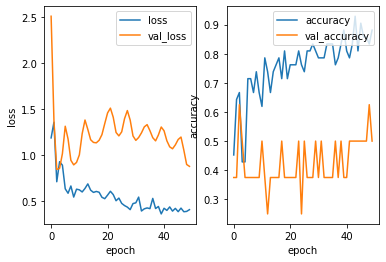

In [30]:
utils.plot_history(history, ('loss', 'accuracy'));

In [31]:
out = transformer_model.predict(X_test, verbose=0)
yhat = np.argmax(out, axis=1)
print('test accuracy: %.2f%%\n' % (100*np.mean(yhat==y_test)))

test accuracy: 58.33%



In [32]:
abstractor_model = AbstractorClassifier(num_layers=2, num_heads=2, dff=64, input_vocab=2, embedding_dim=64)
abstractor_model.compile(loss=loss, optimizer=create_opt(), metrics=['accuracy'])
abstractor_model(X[:32])
abstractor_model.summary()

Model: "abstractor_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 source_embedder (Embedding)  multiple                 128       
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 encoder (Encoder)           multiple                  83584     
                                                                 
 abstractor (RelationalAbstr  multiple                 151040    
 acter)                                                          
                                                                 
 flatten_5 (Flatten)         multiple                  0         
                                                                 
 final_layer (Dense)         multiple        

In [23]:
history = abstractor_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=1)

Epoch 1/50
3/3 [==============================] - 10s 490ms/step - loss: 1.3898 - accuracy: 0.5176 - val_loss: 0.7040 - val_accuracy: 0.4667
Epoch 2/50
3/3 [==============================] - 0s 67ms/step - loss: 0.9276 - accuracy: 0.4824 - val_loss: 0.7235 - val_accuracy: 0.4667
Epoch 3/50
3/3 [==============================] - 0s 59ms/step - loss: 0.9652 - accuracy: 0.4471 - val_loss: 0.8572 - val_accuracy: 0.5333
Epoch 4/50
3/3 [==============================] - 0s 64ms/step - loss: 0.7825 - accuracy: 0.5294 - val_loss: 0.7872 - val_accuracy: 0.4667
Epoch 5/50
3/3 [==============================] - 0s 62ms/step - loss: 0.8046 - accuracy: 0.5059 - val_loss: 0.6932 - val_accuracy: 0.5333
Epoch 6/50
3/3 [==============================] - 0s 60ms/step - loss: 0.7977 - accuracy: 0.4353 - val_loss: 0.7104 - val_accuracy: 0.5333
Epoch 7/50
3/3 [==============================] - 0s 68ms/step - loss: 0.7768 - accuracy: 0.4706 - val_loss: 0.6872 - val_accuracy: 0.5333
Epoch 8/50
3/3 [=========

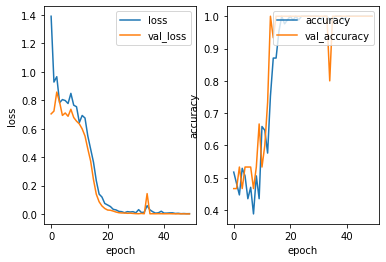

In [24]:
utils.plot_history(history, ('loss', 'accuracy'));

In [26]:
out = abstractor_model.predict(X_test, verbose=0)
yhat = np.argmax(out, axis=1)
print('test accuracy: %.2f%%\n' % (100*np.mean(yhat==y_test)))


test accuracy: 92.44%

